In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <center> TP - Text-Mining <center/>

** Before you begin this notebook, please make sure that you have the data folder + that you are running this notebook from your workspace **

data are here :

https://drive.google.com/drive/folders/1d2hM-NbxT3mGCzRaq-s4nuAAJQcmQj54?usp=sharing


_Now let's practice and use some text-mining techniques!_
<br/>
<br/> In this notebook we will study a mail dataset.
Our final goal is to have some insights about the different subjects that appear in mailboxes. Among other problems, one big issue is that these mailboxes are poluted with a lot of spams.

> The sequence we propose :
- First you'll work on pre-processing the content of the mails
- Then you will try to detect whether a mail is a spam or not through a supervized learning algorithm
- Finally, once you've trained an algorithm to detect spams, you will try to identify the main topics in the remaining non-spam mails

## The data

Data are separated in six parts, each containing around 5000 mails.
<br/> Each of these data chunks are separated in two parts : 
>- hams : that is to say non-spam mails
- spams : containing advertisement or unrelevant content

***
***

## 0. Imports

In [ ]:
#Import usefull package
import os
import re
import string
import random
import numpy as np
import pandas as pd
from collections import Counter

#Import nltk packages to manipulate text
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.metrics import ConfusionMatrix
from nltk.stem.snowball import SnowballStemmer

from nltk import word_tokenize, WordNetLemmatizer, PorterStemmer
from nltk import pos_tag
from nltk import ngrams
from nltk import sent_tokenize

#***
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')


# Let's add a path containing some useful nltk data
nltk.data.path += ['/mnt/share/nltk_data']


# word2vec
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# I. Data ingestion

You should use all data here :

CSV FORMAT :

https://drive.google.com/drive/folders/1_t_lMo3kzqUnOs5sFi3dBuL5dDzKqwXt?usp=sharing

In [ ]:
# You should modify the variable hereunder to you data folder
path_data_all  = 'drive/My Drive/data/dataTM_all/'

## A. Load data

Read all mails

In [ ]:
spams = pd.read_csv(path_data_all + "spams.csv")
hams = pd.read_csv(path_data_all + "hams.csv")

In [ ]:
hams.describe()

,type,text
count,16545,16545
unique,1,15635
top,ham,Subject: calpine daily gas nomination > ricky ...
freq,16545,20


In [ ]:
spams.describe()

,type,text
count,17171,17171
unique,1,14579
top,spam,Subject:
freq,17171,51


# II. Preprocessing

## A. Preprocessing one email

Display one email content

In [ ]:
#Get one spam-email & print it
single_email = hams['text'][0]
print(single_email)

Subject: ena sales on hpl just to update you on this project ' s status : based on a new report that scott mills ran for me from sitara , i have come up with the following counterparties as the ones to which ena is selling gas off of hpl ' s pipe . altrade transaction , l . l . c . gulf gas utilities company brazoria , city of panther pipeline , inc . central illinois light company praxair , inc . central power and light company reliant energy - entex ces - equistar chemicals , lp reliant energy - hl & p corpus christi gas marketing , lp southern union company d & h gas company , inc . texas utilities fuel company duke energy field services , inc . txu gas distribution entex gas marketing company union carbide corporation equistar chemicals , lp unit gas transmission company inc . since i ' m not sure exactly what gets entered into sitara , pat clynes suggested that i check with daren farmer to make sure that i ' m not missing something ( which i did below ) . while i am waiting for a 

### Lower verbatim

Lower the content of the previously displayed mail

In [ ]:
#TODO : lower case the email & print it
lower_mail = single_email.lower()
print(lower_mail)

subject: ena sales on hpl just to update you on this project ' s status : based on a new report that scott mills ran for me from sitara , i have come up with the following counterparties as the ones to which ena is selling gas off of hpl ' s pipe . altrade transaction , l . l . c . gulf gas utilities company brazoria , city of panther pipeline , inc . central illinois light company praxair , inc . central power and light company reliant energy - entex ces - equistar chemicals , lp reliant energy - hl & p corpus christi gas marketing , lp southern union company d & h gas company , inc . texas utilities fuel company duke energy field services , inc . txu gas distribution entex gas marketing company union carbide corporation equistar chemicals , lp unit gas transmission company inc . since i ' m not sure exactly what gets entered into sitara , pat clynes suggested that i check with daren farmer to make sure that i ' m not missing something ( which i did below ) . while i am waiting for a 

### Tokenization

Here we are using a word tokenizer to divide the sentence into tokens

In [ ]:
#TODO : tokenize your email and print it
tokenized_mail = word_tokenize(lower_mail)
print(tokenized_mail[0:100])

['subject', ':', 'ena', 'sales', 'on', 'hpl', 'just', 'to', 'update', 'you', 'on', 'this', 'project', "'", 's', 'status', ':', 'based', 'on', 'a', 'new', 'report', 'that', 'scott', 'mills', 'ran', 'for', 'me', 'from', 'sitara', ',', 'i', 'have', 'come', 'up', 'with', 'the', 'following', 'counterparties', 'as', 'the', 'ones', 'to', 'which', 'ena', 'is', 'selling', 'gas', 'off', 'of', 'hpl', "'", 's', 'pipe', '.', 'altrade', 'transaction', ',', 'l', '.', 'l', '.', 'c', '.', 'gulf', 'gas', 'utilities', 'company', 'brazoria', ',', 'city', 'of', 'panther', 'pipeline', ',', 'inc', '.', 'central', 'illinois', 'light', 'company', 'praxair', ',', 'inc', '.', 'central', 'power', 'and', 'light', 'company', 'reliant', 'energy', '-', 'entex', 'ces', '-', 'equistar', 'chemicals', ',', 'lp']


In [ ]:
#TODO : create bigrams of your email & print it
bigrams = [bigram for bigram in ngrams(tokenized_mail,2)]
bigrams

[('subject', ':'),
 (':', 'ena'),
 ('ena', 'sales'),
 ('sales', 'on'),
 ('on', 'hpl'),
 ('hpl', 'just'),
 ('just', 'to'),
 ('to', 'update'),
 ('update', 'you'),
 ('you', 'on'),
 ('on', 'this'),
 ('this', 'project'),
 ('project', "'"),
 ("'", 's'),
 ('s', 'status'),
 ('status', ':'),
 (':', 'based'),
 ('based', 'on'),
 ('on', 'a'),
 ('a', 'new'),
 ('new', 'report'),
 ('report', 'that'),
 ('that', 'scott'),
 ('scott', 'mills'),
 ('mills', 'ran'),
 ('ran', 'for'),
 ('for', 'me'),
 ('me', 'from'),
 ('from', 'sitara'),
 ('sitara', ','),
 (',', 'i'),
 ('i', 'have'),
 ('have', 'come'),
 ('come', 'up'),
 ('up', 'with'),
 ('with', 'the'),
 ('the', 'following'),
 ('following', 'counterparties'),
 ('counterparties', 'as'),
 ('as', 'the'),
 ('the', 'ones'),
 ('ones', 'to'),
 ('to', 'which'),
 ('which', 'ena'),
 ('ena', 'is'),
 ('is', 'selling'),
 ('selling', 'gas'),
 ('gas', 'off'),
 ('off', 'of'),
 ('of', 'hpl'),
 ('hpl', "'"),
 ("'", 's'),
 ('s', 'pipe'),
 ('pipe', '.'),
 ('.', 'altrade'),
 ('al

In [ ]:
#TODO : create trigrams of your email & print it
trigrams = [bigram for bigram in ngrams(tokenized_mail,3)]
bigrams

[('subject', ':'),
 (':', 'ena'),
 ('ena', 'sales'),
 ('sales', 'on'),
 ('on', 'hpl'),
 ('hpl', 'just'),
 ('just', 'to'),
 ('to', 'update'),
 ('update', 'you'),
 ('you', 'on'),
 ('on', 'this'),
 ('this', 'project'),
 ('project', "'"),
 ("'", 's'),
 ('s', 'status'),
 ('status', ':'),
 (':', 'based'),
 ('based', 'on'),
 ('on', 'a'),
 ('a', 'new'),
 ('new', 'report'),
 ('report', 'that'),
 ('that', 'scott'),
 ('scott', 'mills'),
 ('mills', 'ran'),
 ('ran', 'for'),
 ('for', 'me'),
 ('me', 'from'),
 ('from', 'sitara'),
 ('sitara', ','),
 (',', 'i'),
 ('i', 'have'),
 ('have', 'come'),
 ('come', 'up'),
 ('up', 'with'),
 ('with', 'the'),
 ('the', 'following'),
 ('following', 'counterparties'),
 ('counterparties', 'as'),
 ('as', 'the'),
 ('the', 'ones'),
 ('ones', 'to'),
 ('to', 'which'),
 ('which', 'ena'),
 ('ena', 'is'),
 ('is', 'selling'),
 ('selling', 'gas'),
 ('gas', 'off'),
 ('off', 'of'),
 ('of', 'hpl'),
 ('hpl', "'"),
 ("'", 's'),
 ('s', 'pipe'),
 ('pipe', '.'),
 ('.', 'altrade'),
 ('al

### Lemmatize 

We want to lemmatize the verbatims

In [ ]:
#TODO get lemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
#TODO print lemmatisation of "found" without POS
print('Lemmatisation without POS : found -> ' + lemmatizer.lemmatize('found'))
#TODO print lemmatisation of "found" with POS
print('Lemmatisation with POS : found -> ' + lemmatizer.lemmatize('found',wordnet.VERB))

Lemmatisation without POS : found -> found
Lemmatisation with POS : found -> find


One little subtelty : Lemmatizing efficiently requires to pos_tag the words to know their grammatical nature

### Let's pos_tag the tokens

In [ ]:
#TODO pos_tag your tokenized email & print it
pos_tagged_mail = nltk.pos_tag(tokenized_mail)
pos_tagged_mail

[('subject', 'NN'),
 (':', ':'),
 ('ena', 'NN'),
 ('sales', 'NNS'),
 ('on', 'IN'),
 ('hpl', 'NN'),
 ('just', 'RB'),
 ('to', 'TO'),
 ('update', 'VB'),
 ('you', 'PRP'),
 ('on', 'IN'),
 ('this', 'DT'),
 ('project', 'NN'),
 ("'", "''"),
 ('s', 'JJ'),
 ('status', 'NN'),
 (':', ':'),
 ('based', 'VBN'),
 ('on', 'IN'),
 ('a', 'DT'),
 ('new', 'JJ'),
 ('report', 'NN'),
 ('that', 'IN'),
 ('scott', 'VBZ'),
 ('mills', 'NNS'),
 ('ran', 'NN'),
 ('for', 'IN'),
 ('me', 'PRP'),
 ('from', 'IN'),
 ('sitara', 'NN'),
 (',', ','),
 ('i', 'NN'),
 ('have', 'VBP'),
 ('come', 'VBN'),
 ('up', 'RP'),
 ('with', 'IN'),
 ('the', 'DT'),
 ('following', 'VBG'),
 ('counterparties', 'NNS'),
 ('as', 'IN'),
 ('the', 'DT'),
 ('ones', 'NNS'),
 ('to', 'TO'),
 ('which', 'WDT'),
 ('ena', 'FW'),
 ('is', 'VBZ'),
 ('selling', 'VBG'),
 ('gas', 'NN'),
 ('off', 'IN'),
 ('of', 'IN'),
 ('hpl', 'NN'),
 ("'", "''"),
 ('s', 'JJ'),
 ('pipe', 'NN'),
 ('.', '.'),
 ('altrade', 'JJ'),
 ('transaction', 'NN'),
 (',', ','),
 ('l', 'NN'),
 ('.', '.

In [ ]:
# Try to understand
def get_wordnet_pos(pos_tag):
    """
    Modifies pos_tag to get a more general nature of word
    """
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

### Lemmatizer 

In [ ]:
#TODO: Lemmatize your email without pos & print it
lemmatized_mail_no_pos = [lemmatizer.lemmatize(word[0]) for word in pos_tagged_mail]
print(lemmatized_mail_no_pos)

['subject', ':', 'ena', 'sale', 'on', 'hpl', 'just', 'to', 'update', 'you', 'on', 'this', 'project', "'", 's', 'status', ':', 'based', 'on', 'a', 'new', 'report', 'that', 'scott', 'mill', 'ran', 'for', 'me', 'from', 'sitara', ',', 'i', 'have', 'come', 'up', 'with', 'the', 'following', 'counterparties', 'a', 'the', 'one', 'to', 'which', 'ena', 'is', 'selling', 'gas', 'off', 'of', 'hpl', "'", 's', 'pipe', '.', 'altrade', 'transaction', ',', 'l', '.', 'l', '.', 'c', '.', 'gulf', 'gas', 'utility', 'company', 'brazoria', ',', 'city', 'of', 'panther', 'pipeline', ',', 'inc', '.', 'central', 'illinois', 'light', 'company', 'praxair', ',', 'inc', '.', 'central', 'power', 'and', 'light', 'company', 'reliant', 'energy', '-', 'entex', 'ce', '-', 'equistar', 'chemical', ',', 'lp', 'reliant', 'energy', '-', 'hl', '&', 'p', 'corpus', 'christi', 'gas', 'marketing', ',', 'lp', 'southern', 'union', 'company', 'd', '&', 'h', 'gas', 'company', ',', 'inc', '.', 'texas', 'utility', 'fuel', 'company', 'duke

In [ ]:
##TODO: Lemmatize your email with pos & print it
lemmatized_mail = [lemmatizer.lemmatize(word[0],get_wordnet_pos(word[1])) for word in pos_tagged_mail]
print(lemmatized_mail)

['subject', ':', 'ena', 'sale', 'on', 'hpl', 'just', 'to', 'update', 'you', 'on', 'this', 'project', "'", 's', 'status', ':', 'base', 'on', 'a', 'new', 'report', 'that', 'scott', 'mill', 'ran', 'for', 'me', 'from', 'sitara', ',', 'i', 'have', 'come', 'up', 'with', 'the', 'follow', 'counterparties', 'a', 'the', 'one', 'to', 'which', 'ena', 'be', 'sell', 'gas', 'off', 'of', 'hpl', "'", 's', 'pipe', '.', 'altrade', 'transaction', ',', 'l', '.', 'l', '.', 'c', '.', 'gulf', 'gas', 'utility', 'company', 'brazoria', ',', 'city', 'of', 'panther', 'pipeline', ',', 'inc', '.', 'central', 'illinois', 'light', 'company', 'praxair', ',', 'inc', '.', 'central', 'power', 'and', 'light', 'company', 'reliant', 'energy', '-', 'entex', 'ce', '-', 'equistar', 'chemical', ',', 'lp', 'reliant', 'energy', '-', 'hl', '&', 'p', 'corpus', 'christi', 'gas', 'marketing', ',', 'lp', 'southern', 'union', 'company', 'd', '&', 'h', 'gas', 'company', ',', 'inc', '.', 'texas', 'utility', 'fuel', 'company', 'duke', 'ene

In [ ]:
# Pb with sent because looks like a Noun ...
nltk.pos_tag(["sent"])

[('sent', 'NN')]

In [ ]:
lemmatizer.lemmatize('sent',wordnet.VERB)

'send'

In [ ]:
#TODO: Did we deleted word between tokenization & lemmatization ?
print ('Length Lemmatized single email = ' + str(len(lemmatized_mail)) + ' words')
print ('Length Tokenized single email = ' + str(len(tokenized_mail)) + ' words')

Length Lemmatized single email = 590 words
Length Tokenized single email = 590 words


LEmmatizing doesn't remove words !!!

## Stemmer

In [ ]:
stemmer = SnowballStemmer('english')

In [ ]:

#TODO: stem your email
stemmed_email = [stemmer.stem(word) for word in lemmatized_mail]
print(stemmed_email)

['subject', ':', 'ena', 'sale', 'on', 'hpl', 'just', 'to', 'updat', 'you', 'on', 'this', 'project', "'", 's', 'status', ':', 'base', 'on', 'a', 'new', 'report', 'that', 'scott', 'mill', 'ran', 'for', 'me', 'from', 'sitara', ',', 'i', 'have', 'come', 'up', 'with', 'the', 'follow', 'counterparti', 'a', 'the', 'one', 'to', 'which', 'ena', 'be', 'sell', 'gas', 'off', 'of', 'hpl', "'", 's', 'pipe', '.', 'altrad', 'transact', ',', 'l', '.', 'l', '.', 'c', '.', 'gulf', 'gas', 'util', 'compani', 'brazoria', ',', 'citi', 'of', 'panther', 'pipelin', ',', 'inc', '.', 'central', 'illinoi', 'light', 'compani', 'praxair', ',', 'inc', '.', 'central', 'power', 'and', 'light', 'compani', 'reliant', 'energi', '-', 'entex', 'ce', '-', 'equistar', 'chemic', ',', 'lp', 'reliant', 'energi', '-', 'hl', '&', 'p', 'corpus', 'christi', 'gas', 'market', ',', 'lp', 'southern', 'union', 'compani', 'd', '&', 'h', 'gas', 'compani', ',', 'inc', '.', 'texa', 'util', 'fuel', 'compani', 'duke', 'energi', 'field', 'servi

In [ ]:
#TODO: print the length of your email

print ('Length stemmed single email = ' + str(len(stemmed_email)) + ' words')

Length stemmed single email = 590 words


### Stopwords

In [ ]:
# Have a look at stopwords
stoplist =stopwords.words('english')


#TODO: print example of stop words
print('Example of stop words in english :')
print(stoplist)


Example of stop words in english :
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'on

In [ ]:
#TODO: removing stopwords
mail_no_stopwords = [word for word in stemmed_email if word not in stoplist]
print ('Length single email with stopwords = ' + str(len(stemmed_email)) + ' words')
print ('Length single email without stopwords = ' + str(len(mail_no_stopwords)) + ' words')

Length single email with stopwords = 590 words
Length single email without stopwords = 408 words


In [ ]:
print(stemmed_email)
print('---------------------------------')
print(mail_no_stopwords)

['subject', ':', 'ena', 'sale', 'on', 'hpl', 'just', 'to', 'updat', 'you', 'on', 'this', 'project', "'", 's', 'status', ':', 'base', 'on', 'a', 'new', 'report', 'that', 'scott', 'mill', 'ran', 'for', 'me', 'from', 'sitara', ',', 'i', 'have', 'come', 'up', 'with', 'the', 'follow', 'counterparti', 'a', 'the', 'one', 'to', 'which', 'ena', 'be', 'sell', 'gas', 'off', 'of', 'hpl', "'", 's', 'pipe', '.', 'altrad', 'transact', ',', 'l', '.', 'l', '.', 'c', '.', 'gulf', 'gas', 'util', 'compani', 'brazoria', ',', 'citi', 'of', 'panther', 'pipelin', ',', 'inc', '.', 'central', 'illinoi', 'light', 'compani', 'praxair', ',', 'inc', '.', 'central', 'power', 'and', 'light', 'compani', 'reliant', 'energi', '-', 'entex', 'ce', '-', 'equistar', 'chemic', ',', 'lp', 'reliant', 'energi', '-', 'hl', '&', 'p', 'corpus', 'christi', 'gas', 'market', ',', 'lp', 'southern', 'union', 'compani', 'd', '&', 'h', 'gas', 'compani', ',', 'inc', '.', 'texa', 'util', 'fuel', 'compani', 'duke', 'energi', 'field', 'servi

In [ ]:
#TODO: add some relevant stopwords
stoplist += ['fw','subject']

In [ ]:
#TODO: removing new stopwords
mail_no_stopwords = [word for word in stemmed_email if word not in stoplist]

In [ ]:
print(stemmed_email)
print('---------------------------------')
print(mail_no_stopwords)
print('---------------------------------')
print ('Length single email without stopwords = ' + str(len(mail_no_stopwords)) + ' words' )

['subject', ':', 'ena', 'sale', 'on', 'hpl', 'just', 'to', 'updat', 'you', 'on', 'this', 'project', "'", 's', 'status', ':', 'base', 'on', 'a', 'new', 'report', 'that', 'scott', 'mill', 'ran', 'for', 'me', 'from', 'sitara', ',', 'i', 'have', 'come', 'up', 'with', 'the', 'follow', 'counterparti', 'a', 'the', 'one', 'to', 'which', 'ena', 'be', 'sell', 'gas', 'off', 'of', 'hpl', "'", 's', 'pipe', '.', 'altrad', 'transact', ',', 'l', '.', 'l', '.', 'c', '.', 'gulf', 'gas', 'util', 'compani', 'brazoria', ',', 'citi', 'of', 'panther', 'pipelin', ',', 'inc', '.', 'central', 'illinoi', 'light', 'compani', 'praxair', ',', 'inc', '.', 'central', 'power', 'and', 'light', 'compani', 'reliant', 'energi', '-', 'entex', 'ce', '-', 'equistar', 'chemic', ',', 'lp', 'reliant', 'energi', '-', 'hl', '&', 'p', 'corpus', 'christi', 'gas', 'market', ',', 'lp', 'southern', 'union', 'compani', 'd', '&', 'h', 'gas', 'compani', ',', 'inc', '.', 'texa', 'util', 'fuel', 'compani', 'duke', 'energi', 'field', 'servi

### Punctuation

In [ ]:
#TODO: create a punctuation list
stop_punctuation = [':', '(', ')', '/', '|', ',', ']', ';',
                    '.', '*', '#', '"', '&', '~', '``',
                    '-', '_', '\\', '@','?','!','\'', '[']

In [ ]:
#TODO: removing punctuation & print it
mail_clean = [word for word in mail_no_stopwords if word not in stop_punctuation]

print(mail_clean)
print ('\nLength single email without stopwords = ' + str(len(mail_clean)) + ' words')

['ena', 'sale', 'hpl', 'updat', 'project', 'status', 'base', 'new', 'report', 'scott', 'mill', 'ran', 'sitara', 'come', 'follow', 'counterparti', 'one', 'ena', 'sell', 'gas', 'hpl', 'pipe', 'altrad', 'transact', 'l', 'l', 'c', 'gulf', 'gas', 'util', 'compani', 'brazoria', 'citi', 'panther', 'pipelin', 'inc', 'central', 'illinoi', 'light', 'compani', 'praxair', 'inc', 'central', 'power', 'light', 'compani', 'reliant', 'energi', 'entex', 'ce', 'equistar', 'chemic', 'lp', 'reliant', 'energi', 'hl', 'p', 'corpus', 'christi', 'gas', 'market', 'lp', 'southern', 'union', 'compani', 'h', 'gas', 'compani', 'inc', 'texa', 'util', 'fuel', 'compani', 'duke', 'energi', 'field', 'servic', 'inc', 'txu', 'gas', 'distribut', 'entex', 'gas', 'market', 'compani', 'union', 'carbid', 'corpor', 'equistar', 'chemic', 'lp', 'unit', 'gas', 'transmiss', 'compani', 'inc', 'sinc', 'sure', 'exact', 'get', 'enter', 'sitara', 'pat', 'clyne', 'suggest', 'check', 'daren', 'farmer', 'make', 'sure', 'miss', 'someth', 'w

## B. Preprocessing all emails

### Functions definition 

In [ ]:
def preprocess(sentence):
    """
    Tokenizes, lowers, and stems
    """
    stemmer = SnowballStemmer('english')
    lemmatizer = WordNetLemmatizer()

    # Lower the sentence
    lower_mail = sentence.lower()

    # Tokenize it 
    tokenized_mail = word_tokenize(lower_mail)

    # Get POS for each word
    pos_tagged_mail = nltk.pos_tag(tokenized_mail)

    # Lemmatize
    lemmatized_mail = [lemmatizer.lemmatize(word[0],get_wordnet_pos(word[1])) for word in pos_tagged_mail]

    # Stem
    stemmed_email = [stemmer.stem(word) for word in lemmatized_mail]

    return stemmed_email


In [ ]:
print(preprocess("Hello, my name is toto"))

['hello', ',', 'my', 'name', 'be', 'toto']


## IV. Vectorization

In [ ]:
hams.head()

,type,text
0,ham,Subject: ena sales on hpl just to update you o...
1,ham,Subject: 98 - 6736 & 98 - 9638 for 1997 ( ua 4...
2,ham,"Subject: hpl nominations for december 28 , 199..."
3,ham,"Subject: revised nom - kcs resources daren , i..."
4,ham,Subject: new production - sitara deals needed ...


# TFIDF

In [ ]:
#clean text ie preprocess + remove stop words and punctuation
def clean_text(text):
    text_preprocessed = preprocess(text)
    #clean_mail_tmp = [word for word in text_preprocessed if word not in stoplist]
    clean_mail = [word for word in text_preprocessed if word not in stop_punctuation and not word in stoplist]
    return ' '.join(clean_mail)

In [ ]:
print(clean_text("Hello, my name is toto"))

hello name toto


In [ ]:
# creating a new column with cleaned content for hams
hams["clean_content"]=hams.text.apply(clean_text)


In [ ]:
# creating a new column with cleaned content for spams
spams["clean_content"]=spams.text.apply(clean_text)

In [ ]:
hams.head(5)

,type,text,clean_content
0,ham,Subject: ena sales on hpl just to update you o...,ena sale hpl updat project status base new rep...
1,ham,Subject: 98 - 6736 & 98 - 9638 for 1997 ( ua 4...,98 6736 98 9638 1997 ua 4 issu abov refer mete...
2,ham,"Subject: hpl nominations for december 28 , 199...",hpl nomin decemb 28 1999 see attach file hpll ...
3,ham,"Subject: revised nom - kcs resources daren , i...",revis nom kcs resourc daren bob forward robert...
4,ham,Subject: new production - sitara deals needed ...,new product sitara deal need daren fyi bob for...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# define tfidf for hams, apply tranform et get feature names
tfidf = TfidfVectorizer(use_idf=True)
X_hams = tfidf.fit_transform(hams.clean_content)
features_hams = tfidf.get_feature_names()

In [ ]:
# get most important words
df_hams = pd.DataFrame(X_hams[0].T.todense(), index=features_hams, columns=["TF-IDF"])
df_hams = df_hams.sort_values('TF-IDF', ascending=False)
print (df_hams.head(15))

            TF-IDF
ena       0.340768
compani   0.242816
hpl       0.239767
gas       0.237789
sitara    0.217198
inc       0.195207
lp        0.167581
cheryl    0.166892
pipe      0.150991
sell      0.143602
dudley    0.138881
deal      0.133625
equistar  0.126106
ect       0.123440
chemic    0.120421


In [ ]:
# define tfidf for spams, apply tranform et get feature names

X_spams = tfidf.fit_transform(spams.clean_content)
features_spams = tfidf.get_feature_names()

In [ ]:
# get most important words
df_spams = pd.DataFrame(X_spams[0].T.todense(), index=features_spams, columns=["TF-IDF"])
df_spams = df_spams.sort_values('TF-IDF', ascending=False)
print (df_spams.head(15))

                 TF-IDF
naturalgolden  0.174546
meganbang      0.174546
ole            0.169344
shoehorn       0.169344
bld            0.165308
intervenor     0.159224
look           0.157819
pietism        0.156809
honeycomb      0.156809
lookup         0.154679
skeleton       0.154679
retract        0.152774
res            0.152774
scaup          0.152774
brandywin      0.152774


# Let's try to use word2vec

Useful link for Word2Vec API : https://radimrehurek.com/gensim/models/word2vec.html

In [ ]:
w2v_model = Word2Vec(window=4,
                     min_count=20,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     size=25)

In [ ]:
#TODO : create a Word2vect space using all ham emails
#content_w2v = Word2Vec(['My','name','is','toto','and','i','am','glad','to','be','here'], size=20, window=5)

#word2vec = Word2Vec(['My','name','is','toto','and','i','am','glad','to','be','here'], min_count=2)

w2v_model.build_vocab([word_tokenize(sentence) for sentence in hams.clean_content])

In [ ]:
#TODO: find most similar word for hello
#word2vec.wv.most_similar('name')

vocabulary = word2vec.wv.vocab
print(vocabulary)

NameError: ignored

In [ ]:
#TODO: find most similar word for pay
w2v_model.wv.most_similar('enron')

[('rimer', 0.6868952512741089),
 ('989', 0.6628721952438354),
 ('677', 0.657296895980835),
 ('669', 0.6524802446365356),
 ('handlowej', 0.6521056294441223),
 ('eml', 0.6357815861701965),
 ('microwav', 0.6342266798019409),
 ('circl', 0.6266490817070007),
 ('luci', 0.6257796287536621),
 ('dyersdal', 0.6244508028030396)]

In [ ]:
#TODO: find most similar word for a punctuation
w2v_model.wv.most_similar('.')

KeyError: ignored

In [ ]:
#TODO: show the vector of one word
w2v_model['enron']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([ 0.01555214,  0.01417663, -0.01815792,  0.00565587,  0.00616158,
       -0.01404526, -0.01383935,  0.01774728,  0.01530855, -0.00327919,
        0.00025413, -0.00563626,  0.01901538,  0.00717324, -0.00925716,
       -0.00365147, -0.01569095,  0.00353409, -0.01126589,  0.00028959,
       -0.01234843,  0.0190894 ,  0.00212715, -0.01598966,  0.01321758],
      dtype=float32)

In [ ]:
#TODO: find the word which doesn't match in {pay, money, cash, start}
w2v_model.wv.doesnt_match('pay money cash start'.split(' '))

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'cash'

In [ ]:
# similarity
w2v_model.wv.similarity("enron", 'nippon')

0.084869556

# V - Classification


## 1. Split data for spam detection learning

We now split the data between train and test (proportion 80%/20%)

>**reminder**
<br/>
- Training set : data on which we are going to learn what is a spam and what is a ham
- Testing set : data that we will keep isolated, and on which we will test the algorithm. the model will never have seen these data when working on it

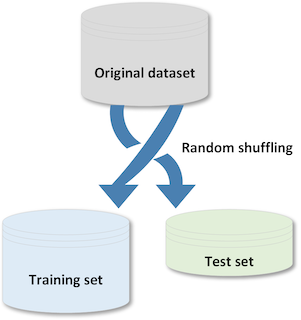

In [ ]:
hams_list = hams.clean_content.to_list()
spams_list = spams.clean_content.to_list()

Add its label to each mail

In [ ]:
# TODO : Split data into train & test using train_test_split function

from sklearn.model_selection import train_test_split

train_hams, test_hams = train_test_split(hams_list, train_size=0.8, test_size=0.2, shuffle=False)
train_spams, test_spams = train_test_split(spams_list, train_size=0.8, test_size=0.2, shuffle=False)



In [ ]:
# TODO create a feature and label vector for all mails

train_set = [(mail,'spam') for mail in train_spams] + [(mail,'ham') for mail in train_hams]
print('Train set size = ' + str(len(train_set)) + ' emails')

test_set = [(mail,'spam') for mail in test_spams] + [(mail,'ham') for mail in test_hams]
print('Test set size = ' + str(len(test_set)) + ' emails')



Train set size = 26972 emails
Test set size = 6744 emails


In [ ]:
# tokenize each mail
def get_features(text):
    return {word: True for word in word_tokenize(text)}

In [ ]:
# extract the features
all_features_train = [(get_features(email), label) for (email, label) in train_set]
print ('Collected ' + str(len(all_features_train)) + ' feature sets')

# extract the features
all_features_test = [(get_features(email), label) for (email, label) in test_set]
print ('Collected ' + str(len(all_features_test)) + ' feature sets')

Collected 26972 feature sets
Collected 6744 feature sets


In [ ]:
all_features_train[1]

({'%': True,
  'clck': True,
  'complet': True,
  'confirm': True,
  'ebay': True,
  'express': True,
  'feder': True,
  'fedex': True,
  'fortun': True,
  'futur': True,
  'januari': True,
  'learn': True,
  'like': True,
  'mail': True,
  'make': True,
  'money': True,
  'number': True,
  'order': True,
  'random': True,
  'receiv': True,
  'regist': True,
  'ship': True,
  'softwar': True,
  'system': True,
  'thank': True,
  'track': True,
  'turnkey': True,
  'turori': True,
  'userid': True,
  'via': True,
  'video': True,
  'want': True,
  'word': True,
  'would': True},
 'spam')

In [ ]:
train_set_NB = [(feature[0],feature[1]) for feature in all_features_train]

test_set_NB = [(feature[0],feature[1]) for feature in all_features_test]

In [ ]:
train_set_NB[0]

({'acc': True,
  'add': True,
  'aitken': True,
  'amaz': True,
  'anyon': True,
  'babe': True,
  'bio': True,
  'biz': True,
  'bld': True,
  'brand': True,
  'brandywin': True,
  'browser': True,
  'byrn': True,
  'cam': True,
  'catatonia': True,
  'catfish': True,
  'com': True,
  'come': True,
  'companion': True,
  'copi': True,
  'counterattack': True,
  'creat': True,
  'date': True,
  'develop': True,
  'electrocardiograph': True,
  'encomium': True,
  'even': True,
  'everi': True,
  'fashion': True,
  'find': True,
  'form': True,
  'friendship': True,
  'good': True,
  'help': True,
  'honeycomb': True,
  'http': True,
  'intervenor': True,
  'line': True,
  'look': True,
  'lookup': True,
  'love': True,
  'matter': True,
  'may': True,
  'meganbang': True,
  'monster': True,
  'movi': True,
  'naturalgolden': True,
  'new': True,
  'ole': True,
  'pa': True,
  'pietism': True,
  'plz': True,
  'preemptiv': True,
  'quick': True,
  'res': True,
  'retract': True,
  'road'

## 2. Define Classifier Models

In [ ]:


# Definition of the classification function using Naive Bayes model

from nltk import NaiveBayesClassifier, classify




In [ ]:
# Definition of the classification function using Logistic Regression
# TODO

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

### Let's train  models on preproced data

In [ ]:
#TODO: train the Naive Bayes classifier for all_features

NBclassifier = NaiveBayesClassifier.train(train_set_NB)

In [ ]:
#TODO: show most informative features

NBclassifier.show_most_informative_features(10)

Most Informative Features
                   enron = True              ham : spam   =   4471.1 : 1.0
                     hpl = True              ham : spam   =    485.5 : 1.0
                     php = True             spam : ham    =    483.4 : 1.0
                   corel = True             spam : ham    =    268.2 : 1.0
                        = True              ham : spam   =    256.3 : 1.0
              macromedia = True             spam : ham    =    241.9 : 1.0
                   louis = True              ham : spam   =    238.1 : 1.0
                     eol = True              ham : spam   =    214.8 : 1.0
                     713 = True              ham : spam   =    207.9 : 1.0
                   daren = True              ham : spam   =    196.3 : 1.0


In [ ]:
#TODO: evaluate accuracy of the model

print ('Accuracy of the test set = ' + str(classify.accuracy(NBclassifier, test_set_NB)))

Accuracy of the test set = 0.9863582443653618


In [ ]:

#TODO: train the Logistic Regression classifier for all_features
from nltk.classify import SklearnClassifier
from sklearn.linear_model import LogisticRegression

classifLog = SklearnClassifier(LogisticRegression())
classifLog.train(train_set_NB)

<SklearnClassifier(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False))>

In [ ]:
#TODO: show most informative features
classifLog.show_most_informative_features(10)

AttributeError: ignored

In [ ]:
#TODO: evaluate accuracy of the model & compare with the previous model

print ('Accuracy of the test set = ' + str(classify.accuracy(classifLog, test_set_NB)))

Accuracy of the test set = 0.9739027283511269


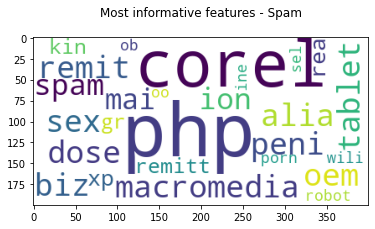

In [ ]:
#TODO: create a wordcloud with most informative features for spam for NBC & LR


from wordcloud import WordCloud

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline



# Complicated
def most_informative_features_by_label(classifier, label, n=50):
    """
    Returns features and their importance
    """
    cpdist = classifier._feature_probdist
    feature_list = []
    for (fname, fval) in classifier.most_informative_features(n):
        def labelprob(l):
            return cpdist[l, fname].prob(fval)
        labels = sorted([l for l in classifier._labels if fval in cpdist[l, fname].samples()], 
                        key=labelprob)
        if labels[-1] == label:
            feature_list.append(fname)
    return feature_list

wordcloud_spam = WordCloud(background_color='white').generate(' '.join(most_informative_features_by_label(NBclassifier,'spam')))
plt.imshow(wordcloud_spam)
plt.title("Most informative features - Spam\n")
plt.axis()
plt.show()

### Indicators of model quality


In [ ]:

#TODO: show confusion matrix on test set ++ precision on spam prediction on test set + recall on spam prediction on test set for NBC & LRC

# variables

test_features = [feature[0] for feature in test_set_NB]
test_label = [feature[1] for feature in test_set_NB]
prediction = NBclassifier.classify_many(test_features)

#TODO: show confusion matrix on test set ++ precision on spam prediction on test set + recall on spam prediction on test set

cm = ConfusionMatrix(test_label, prediction)
print("Confusion Matrix on test set" )
print(cm)

Confusion Matrix on test set
     |         s |
     |    h    p |
     |    a    a |
     |    m    m |
-----+-----------+
 ham |<3268>  41 |
spam |   51<3384>|
-----+-----------+
(row = reference; col = test)

